In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img1 = cv2.imread('000006-color.jpg', cv2.COLOR_BGR2GRAY)#cv.IMREAD_GRAYSCALE)
img2 = cv2.imread('000007-color.jpg', cv2.COLOR_BGR2GRAY)#cv.IMREAD_GRAYSCALE)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

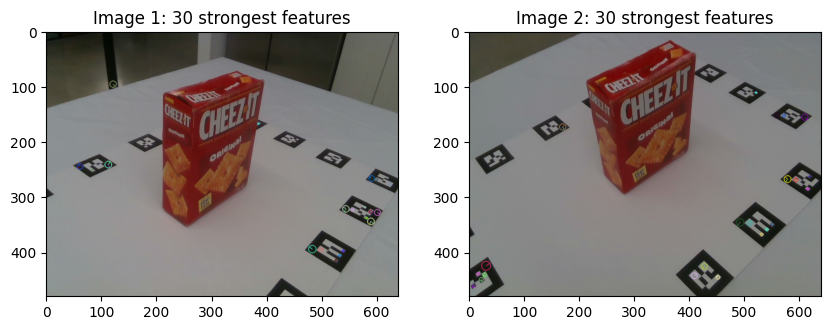

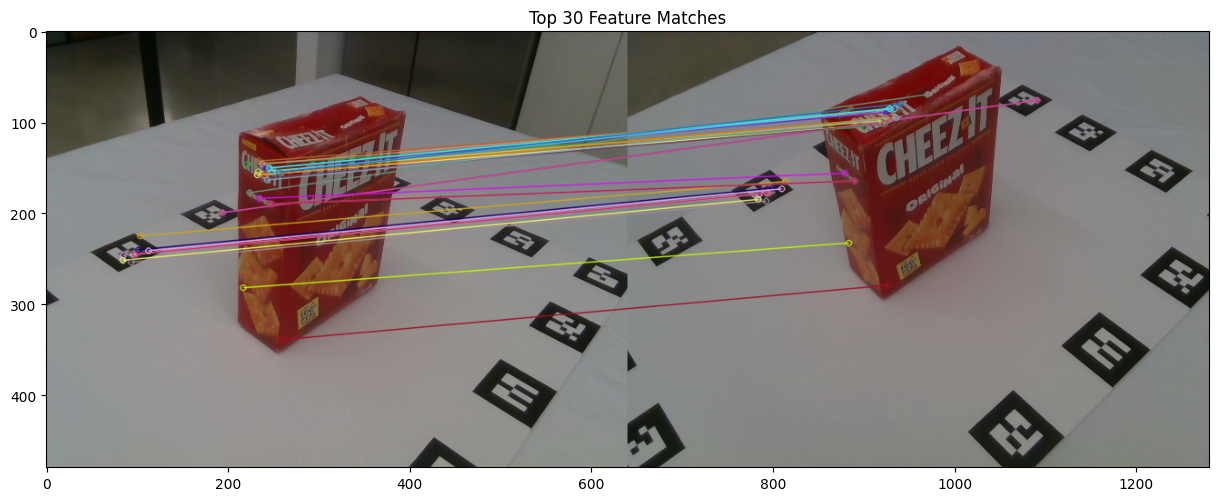

In [16]:
# Use SIFT for feature detection
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Draw the 30 strongest keypoints
img1_kp = cv2.drawKeypoints(img1, sorted(kp1, key=lambda x: -x.response)[:30], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kp = cv2.drawKeypoints(img2, sorted(kp2, key=lambda x: -x.response)[:30], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Image 1: 30 strongest features')
plt.imshow(cv2.cvtColor(img1_kp, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.title('Image 2: 30 strongest features')
plt.imshow(cv2.cvtColor(img2_kp, cv2.COLOR_BGR2RGB))
plt.show()

# Feature matching
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)
# Apply ratio test
good = []
pts1 = []
pts2 = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good[:30], None, flags=2)
plt.figure(figsize=(15,7))
plt.title('Top 30 Feature Matches')
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
# Select inlier points
pts1_inliers = pts1[mask.ravel() == 1]
pts2_inliers = pts2[mask.ravel() == 1]
print('Fundamental Matrix:\n', F)

Fundamental Matrix:
 [[-1.67456906e-05  1.78421632e-05  4.95908581e-02]
 [-8.64948652e-06  2.49728924e-05  4.43036726e-02]
 [-4.04550535e-02 -5.70620042e-02  1.00000000e+00]]


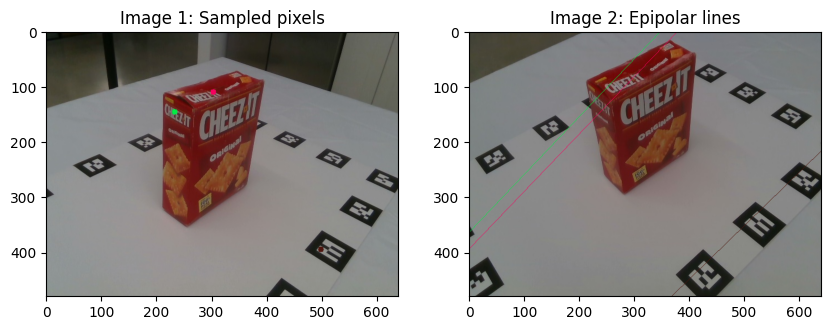

In [15]:
def drawlines(img1, img2, lines, pts1, pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1.shape[:2]
    img1 = img1.copy()
    img2 = img2.copy()
    for r_line, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0, y0 = map(int, [0, -r_line[2]/r_line[1]])
        x1, y1 = map(int, [c, -(r_line[2]+r_line[0]*c)/r_line[1]])
        img2 = cv2.line(img2, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1, tuple(pt1),5,color,-1)
    return img1, img2

# Pick 3 random points
idx = np.random.choice(len(pts1_inliers), 3, replace=False)
pts1_sample = pts1_inliers[idx]
pts2_sample = pts2_inliers[idx]

# Find epilines in image 2 for points in image 1
lines2 = cv2.computeCorrespondEpilines(pts1_sample.reshape(-1,1,2), 1, F)
lines2 = lines2.reshape(-1,3)
img1_epi, img2_epi = drawlines(img1, img2, lines2, pts1_sample, pts2_sample)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Image 1: Sampled pixels')
plt.imshow(cv2.cvtColor(img1_epi, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.title('Image 2: Epipolar lines')
plt.imshow(cv2.cvtColor(img2_epi, cv2.COLOR_BGR2RGB))
plt.show()

Number of inliers: 119


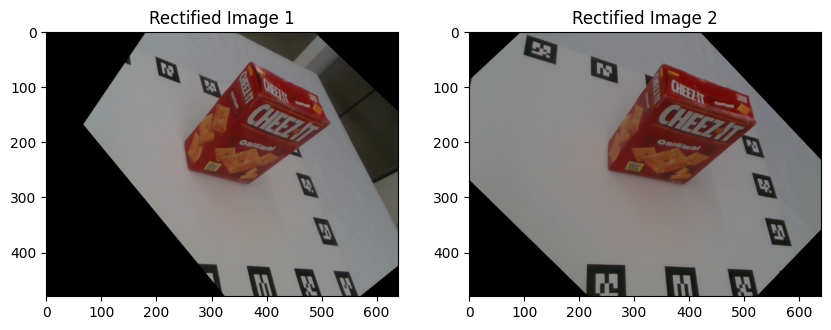

In [11]:
print("Number of inliers:", len(pts1_inliers))
if len(pts1_inliers) < 8:
    print("Not enough inliers for rectification.")
else:
    retval, h1, h2 = cv2.stereoRectifyUncalibrated(
        pts1_inliers, pts2_inliers, F, imgSize=img1_gray.shape[::-1]
    )
    if not retval:
        print("Rectification failed. Not enough inliers or degenerate configuration.")
    else:
        img1_rect = cv2.warpPerspective(img1, h1, (img1.shape[1], img1.shape[0]))
        img2_rect = cv2.warpPerspective(img2, h2, (img2.shape[1], img2.shape[0]))

        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.title('Rectified Image 1')
        plt.imshow(cv2.cvtColor(img1_rect, cv2.COLOR_BGR2RGB))
        plt.subplot(1,2,2)
        plt.title('Rectified Image 2')
        plt.imshow(cv2.cvtColor(img2_rect, cv2.COLOR_BGR2RGB))
        plt.show()

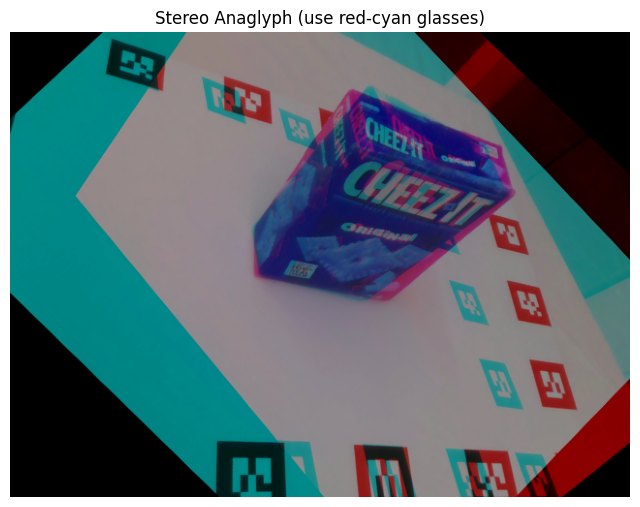

In [21]:
def make_anaglyph(imgL, imgR):
    # Normalize and convert to float
    imgL = imgL.astype(np.float32) / 255.0
    imgR = imgR.astype(np.float32) / 255.0
    # Red from left, green/blue from right
    anaglyph = np.zeros_like(imgL)
    anaglyph[...,0] = imgL[...,0] # Blue
    anaglyph[...,1] = imgR[...,1] # Green
    anaglyph[...,2] = imgR[...,2] # Red
    return (anaglyph * 255).astype(np.uint8)

anaglyph = make_anaglyph(img1_rect, img2_rect)
plt.figure(figsize=(8,8))
plt.title('Stereo Anaglyph (use red-cyan glasses)')
plt.imshow(anaglyph)
plt.axis('off')
plt.show()